<a href="https://colab.research.google.com/github/ollivierj/projet/blob/master/secteurs_geographiques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse des secteurs géographiques

## Objectifs
- Analyser comment sont repartis géographiquement les cabinets et entreprises en tenant compte de leurs licences PREMIUM 
- Identifier les clusters géographiques 

In [1]:
# installation de packages supplementaires
!pip install -U -q PyDrive chart_studio kneed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 KB 3.7 MB/s eta 0:00:00


In [2]:
# imports
import os
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
import numpy as np
from sklearn.cluster import KMeans
import geopy
from sklearn import preprocessing, cluster
import scipy
from yellowbrick.cluster import KElbowVisualizer
import warnings
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from kneed import KneeLocator
#import minisom

In [3]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [4]:
def dbscan_cluster(latitudes,longitudes,epsilon,min_samples,**kwargs):
    '''
    Function to perform DBSCAN clustering for given parameters.
    
    '''
    
    # convert epsilon from km to radians
    kms_per_radian = 6371.0088
    epsilon /= kms_per_radian
    
    # set up the algorithm
    dbscan = DBSCAN(
        eps = epsilon,
        min_samples = min_samples,
        algorithm = 'ball_tree',
        metric = 'haversine',
        **kwargs
    )
    
    # fit the algorithm
    return dbscan.fit(
        np.radians(
            [x for x in zip(latitudes,longitudes)]
        )
    )
    

In [5]:
# paramétrage
plt.rcParams['font.size'] = 14
plt.figure(figsize=(12,5))
palette = sns.color_palette('Paired', 10)
pd.options.display.max_columns = None
pd.options.display.width = 1000
pd.options.display.max_seq_items = None
warnings.filterwarnings('ignore')
os.getcwd()

'/content'

<Figure size 864x360 with 0 Axes>

In [6]:
# Authentification et instantitaion client google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
# Récupération du CSV depuis le drive
dl = drive.CreateFile({'id':'1WWDSvz02GG7gbMbc-3NUZOaNRYJByDxX'})
dl.GetContentFile('dataset.csv')  
df = pd.read_csv('dataset.csv')

In [8]:
df.describe()

,DIST_KM,ENT_ID,ENT_SIRET,CAB_ID,ENT_NB_PREM,ENT_AGE_EDITION,ENT_AGE_ACCES,ENT_CAP_NUM,ENT_AGE_MEG,ENT_AGE_ENT,ENT_NIC,ENT_DIV_NAF,ENT_GRP_NAF,ENT_CLS_NAF,ENT_LAT,ENT_LON,ENT_CAT_JUR_NIV1,ENT_CAT_JUR_NIV2,ENT_CAT_JUR_NIV3,CAB_ID.1,CAB_SIRET,CAB_AGE_MEG,CAB_PRIX_PREMIUM,CAB_PRIX_BNC,CAB_NB_PREM_DIS,CAB_NB_PREM_FAC,CAB_NB_PREM_TEST,CAB_NB_PREM_AFF,CAB_NB_PREM_NOT_AFF,CAB_MT_PREM_HONO,CAB_NB_PREM_HONO,CAB_AGE_CAB,CAB_NIC,CAB_DIV_NAF,CAB_GRP_NAF,CAB_CLS_NAF,CAB_LAT,CAB_LON,CAB_CAT_JUR_NIV1,CAB_CAT_JUR_NIV2,CAB_CAT_JUR_NIV3,ENT_ID.1,NB_HITS_ACH,NB_HITS_EXP,NB_HITS_NDF,NB_HITS_TDB,NB_HITS_BQ,NB_HITS_FAC,NB_HITS_CAI,NB_HITS_BAT
count,195911.000000,206678.000000,2.007520e+05,206678.000000,206678.000000,168281.000000,169075.000000,1.878170e+05,206678.000000,197527.000000,197533.000000,197282.000000,197282.000000,197282.000000,197480.000000,197480.000000,197531.00000,197531.000000,197531.000000,206678.000000,2.057940e+05,195762.000000,3149.000000,1015.0,206678.000000,206678.000000,206678.000000,206678.000000,206678.000000,206678.000000,206678.000000,205004.000000,205004.000000,200529.000000,200529.000000,200529.000000,205004.000000,205004.000000,205004.000000,205004.000000,205004.000000,141643.000000,141643.000000,141643.000000,141643.000000,141643.000000,141643.0,141643.000000,141643.000000,141643.000000
mean,106.733676,192970.013393,7.367245e+13,4380.140073,0.167149,6.168358,7.641795,9.524374e+04,35.696654,90.993182,21.896554,59.333482,59.625566,59.647044,45.814413,2.346403,4.54111,49.818828,5030.377900,4380.140073,5.389294e+13,94.769182,11.703715,5.0,60.616911,57.392645,1.262321,53.981769,6.635143,573.116020,57.408447,230.416687,179.965371,68.960031,69.160815,69.162856,45.911421,2.329034,5.031424,55.419445,5600.241507,196850.722485,2.921542,6.035921,2.538156,0.087551,0.0,203.689134,32.962173,0.192209
std,513.355681,85358.796328,1.879258e+13,2237.435313,0.396473,14.145075,15.811580,8.562354e+06,26.039081,116.329528,178.716823,20.237488,20.192911,20.191809,7.353947,7.914822,1.62361,17.901449,1805.825236,2237.435313,1.987743e+13,35.976738,2.370172,0.0,138.503921,134.508018,1.120139,135.597195,16.313191,1350.464033,134.509556,260.225088,992.337321,2.549735,2.570713,2.573531,7.083079,7.609355,1.032809,10.698250,1069.852347,81581.989719,28.353171,10.881851,23.771306,1.053018,0.0,596.565657,90.831731,7.679271
min,0.000000,9117.000000,0.000000e+00,1231.000000,0.000000,0.032258,0.032258,-2.092767e+09,0.032258,-10.000000,10.000000,1.000000,1.100000,1.110000,-21.339621,-63.055071,1.00000,10.000000,1000.000000,1231.000000,1.715120e+12,0.419355,10.000000,5.0,0.000000,-1.000000,0.000000,0.000000,-13.000000,0.000000,-1.000000,0.870968,10.000000,13.000000,13.900000,13.920000,-21.312266,-63.055071,1.000000,10.000000,1000.000000,9117.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,6.228975,121842.250000,5.229966e+13,2425.000000,0.000000,0.129032,0.064516,0.000000e+00,13.741935,28.161290,14.000000,46.000000,46.100000,46.160000,44.634191,-0.307710,5.00000,54.000000,5499.000000,2425.000000,3.849315e+13,67.483871,10.000000,5.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,97.838710,20.000000,69.000000,69.200000,69.200000,44.791654,-0.369889,5.000000,54.000000,5499.000000,131413.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000
50%,20.259537,199503.500000,8.245268e+13,3905.000000,0.000000,0.483871,0.419355,1.000000e+03,31.580645,59.612903,17.000000,63.000000,63.100000,63.120000,47.045655,2.359999,5.00000,54.000000,5499.000000,3905.000000,4.800705e+13,98.741935,10.000000,5.0,12.000000,10.000000,1.000000,9.000000,2.000000,130.000000,10.000000,167.709677,31.000000,69.000000,69.200000,69.200000,47.203016,2.342785,5.000000,55.000000,5599.000000,206482.000000,0.000000,3.000000,0.000000,0.000000,0.0,32.000000,0.000000,0.000000
75%,67.364910,267516.750000,8.826661e+13,6069.000000,0.000000,3.129032,5.000000,5.000000e+03,55.483871,111.741935,25.000000,70.000000,70.200000,70.220000,48.715492,4.802

In [9]:
df.dtypes

DIST_KM        float64
ENT_ID           int64
ENT_SIRET      float64
ENT_NOM         object
CAB_ID           int64
                ...   
NB_HITS_TDB    float64
NB_HITS_BQ     float64
NB_HITS_FAC    float64
NB_HITS_CAI    float64
NB_HITS_BAT    float64
Length: 105, dtype: object

In [10]:
# Conversion de types
df['CAB_DATE_MEG']=pd.to_datetime(df['CAB_DATE_MEG'])

In [11]:
df.columns

Index(['DIST_KM', 'ENT_ID', 'ENT_SIRET', 'ENT_NOM', 'CAB_ID', 'HAS_ENT_FAC', 'HAS_ENT_IDF', 'HAS_ENT_ACH', 'HAS_ENT_ACH.1', 'HAS_ENT_CAISSE', 'HAS_ENT_TDB', 'HAS_ENT_BQ', 'HAS_ENT_PDB', 'ENT_LIC', 'ENT_NB_PREM', 'ENT_AGE_EDITION', 'ENT_AGE_ACCES', 'ENT_TYPE_CAP', 'ENT_REG_FISC', 'ENT_CAP_NUM', 'ENT_REG_IMP', 'ENT_FORM_JUR', 'ENT_TYPE_TVA', 'ENT_ACT_TVA', 'ENT_REG_TVA', 'ENT_TYPE_COMPTA', 'ENT_TYPE_PACK_LIC', 'ENT_SECT_ACT', 'ENT_AGE_MEG', 'ENT_DATE_MEG', 'ENT_DIFFUSABLE', 'ENT_AGE_ENT', 'ENT_DATE', 'ENT_EFFECTIF', 'ENT_CAT_ENT', 'ENT_ETAT_ADM', 'ENT_NIC', 'ENT_CAR_EMP', 'ENT_SEC_NAF', 'ENT_DIV_NAF', 'ENT_GRP_NAF', 'ENT_CLS_NAF', 'ENT_SS_CLS_NAF', 'ENT_LAT', 'ENT_LON', 'ENT_CAT_JUR_NIV1', 'ENT_CAT_JUR_NIV2', 'ENT_CAT_JUR_NIV3', 'ENT_CODE_COMMUNE', 'CAB_ID.1', 'CAB_SIRET', 'CAB_NOM', 'CAB_AGE_MEG', 'CAB_DATE_MEG', 'HAS_CAB_FAC', 'HAS_CAB_IDF', 'HAS_CAB_ACH', 'HAS_CAB_ACH.1', 'HAS_CAB_CAISSE', 'HAS_CAB_TDB', 'HAS_CAB_BQ', 'HAS_CAB_PDB', 'CAB_NOM.1', 'CAB_DIA', 'CAB_TYPE_ACT',
       'CAB_

In [12]:
# Ajout d'une colonne technique pour faciliter les décomptes
df["COUNT"]=1

## Heatmap des entreprises (majoration selon nombre de licences PREMIUM)

In [13]:
df_ent=df.copy()

In [14]:
center_location = [46.2276, 2.2137]
m_ent = folium.Map(location=center_location, control_scale=True, zoom_start=6)
heatmap_data_ent = df_ent[df.ENT_AGE_EDITION <= 12][['ENT_LAT', 'ENT_LON']].groupby(['ENT_LAT', 'ENT_LON']).sum().reset_index().values.tolist()
HeatMap(data=heatmap_data_ent, gradient={0.4: 'blue', 0.45: 'lime', 0.5: 'yellow', 0.55: 'orange', 0.6: 'red'}, 
                radius=7,
                use_local_extrema=False, max_zoom=13).add_to(m_ent)
m_ent

## Heatmap des cabinets principaux (majoration selon nombre de licences PREMIUM)

In [15]:
df_cab=df.copy()

In [16]:
m_cab = folium.Map(location=center_location, control_scale=True, zoom_start=6)
heatmap_data_cab = df_cab[['CAB_LAT', 'CAB_LON']].groupby(['CAB_LAT', 'CAB_LON']).sum().reset_index().values.tolist()
HeatMap(data=heatmap_data_cab, gradient={0.4: 'blue', 0.45: 'lime', 0.5: 'yellow', 0.55: 'orange', 0.6: 'red'}, 
                
                radius=7,
                use_local_extrema=False, max_zoom=13).add_to(m_cab)
m_cab

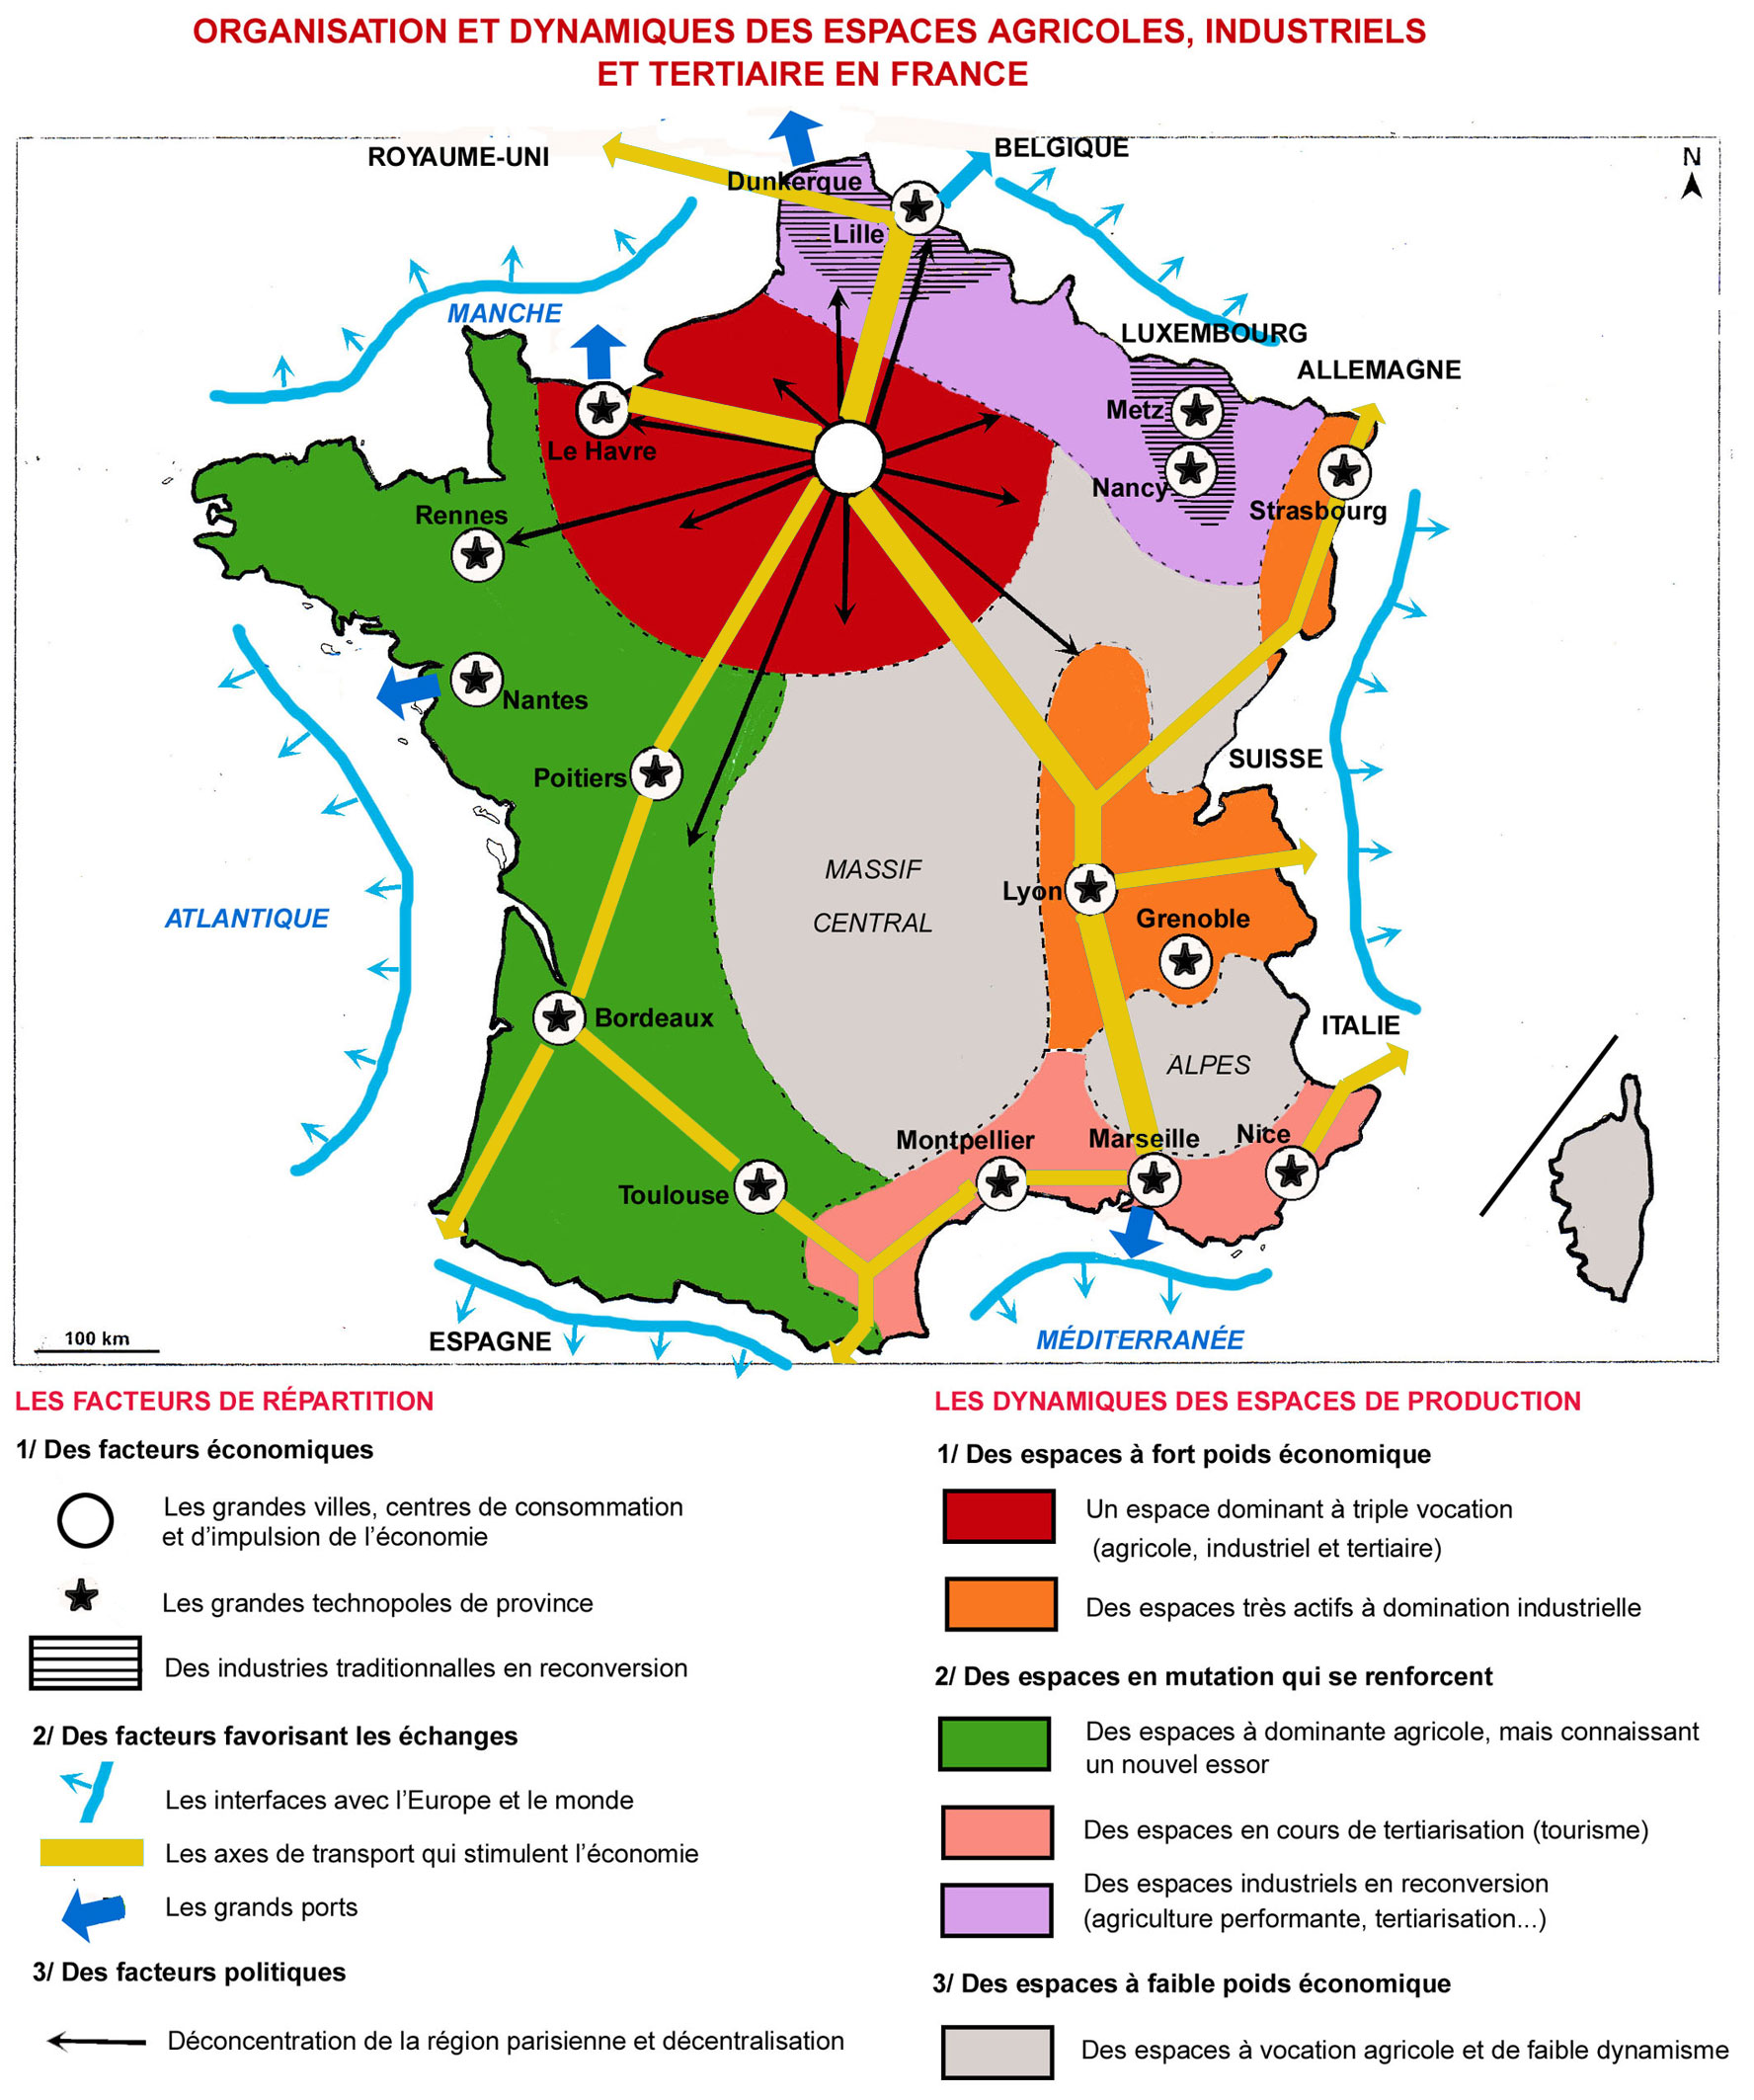

In [17]:
dl = drive.CreateFile({'id':'1m4JzJlZ_A9uNTUw5U1eC65MH0QR4pGHJ'}) 
dl.GetContentFile('orga-dyn-espaces-agr-indus-tert.png')  
Image(filename='orga-dyn-espaces-agr-indus-tert.png')

In [18]:
heatmap_cab_data_by_year = []
for year in df_cab.CAB_DATE_MEG.dt.year.sort_values().dropna().unique():
    _df = df_cab[df_cab.CAB_DATE_MEG.dt.year <= year][['CAB_LAT', 'CAB_LON']].groupby(['CAB_LAT', 'CAB_LON']).sum().reset_index().values.tolist()
    heatmap_cab_data_by_year.append(_df)

In [19]:
m_cab_with_time = folium.Map(location=center_location, control_scale=True, zoom_start=6)
HeatMapWithTime(heatmap_cab_data_by_year, 
                #gradient={0.: 'blue', 0.45: 'lime', 0.5: 'yellow', 0.55: 'orange', 0.2: 'red'}, 
                min_opacity=0.4, max_opacity=0.4,
                radius=7,
                use_local_extrema=False).add_to(m_cab_with_time)
m_cab_with_time

## Clustering géographique

### Cabinets

In [20]:
df_cab_clustering=df.copy()
df_cab_clustering=df_cab_clustering[(df.CAB_LON.notnull()) & (df.CAB_LAT.notnull())][['CAB_ID', 'CAB_LAT', 'CAB_LON', 'CAB_NOM', 'CAB_DIA']].drop_duplicates()
df_cab_clustering.shape

(3395, 5)

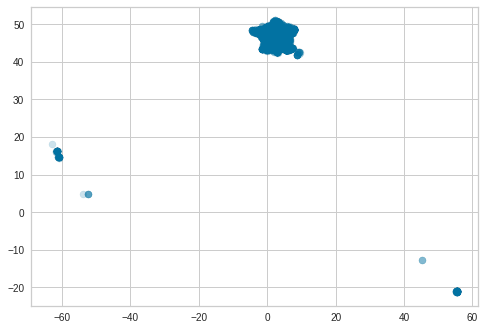

In [21]:
X_cab = np.array(df_cab_clustering[['CAB_LAT','CAB_LON']], dtype='float64')
plt.scatter(X_cab[:,1], X_cab[:,0], alpha=0.2, s=50)

In [22]:
n=5
# n_neighbors as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors = n, algorithm = 'ball_tree', metric = 'haversine').fit(np.radians(
            [x for x in zip(X_cab[:,0], X_cab[:,1])]
        ))

neigh_dist, neigh_ind = nbrs.kneighbors(np.radians(
            [x for x in zip(X_cab[:,0], X_cab[:,1])]
        ))
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis = 0)
k_dist = sort_neigh_dist[:, n-1]
k_dist=[x * 6371000/1000 for x in k_dist]

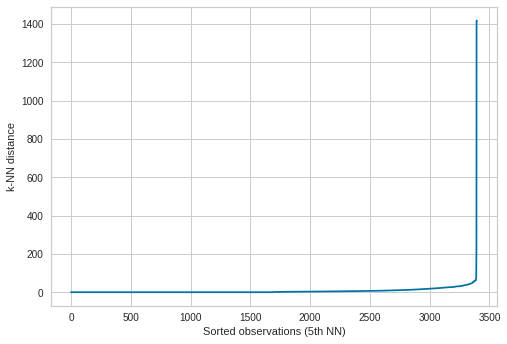

In [23]:
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations ("+ str(n) + "th NN)")
plt.show()

In [24]:
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)

# get the estimate of knee point
print(kneedle.knee_y)

61.567944021582946


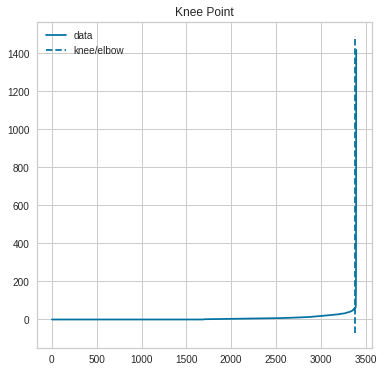

In [25]:
kneedle.plot_knee()
plt.show()

In [26]:
clusters=dbscan_cluster(X_cab[:,0], X_cab[:,1], kneedle.knee_y, 64)
# get cluster labels
set(clusters.labels_)
df_cab_clustering['GEO_CLUSTER'] = clusters.labels_
df_cab_clustering.groupby('GEO_CLUSTER')[['CAB_LON', 'CAB_LAT']].describe()

CAB_LON                                                                              CAB_LAT                                                                             
              count       mean        std        min        25%        50%        75%        max   count       mean        std        min        25%        50%        75%        max
GEO_CLUSTER                                                                                                                                                                          
-1            560.0  -5.479886  20.633372 -63.055071  -1.173479   0.359570   3.186398  45.194781   560.0  42.323093  11.260851 -12.790232  43.333466  46.162421  47.896434  50.108462
 0            713.0   2.299404   0.386338   0.712200   2.261968   2.312558   2.421385   3.931608   713.0  48.921641   0.236401  47.914194  48.834962  48.872725  48.904081  49.937897
 1            277.0  -1.623653   0.654827  -3.030708  -1.842661  -1.623009  -1.407896  -0.472306   277.0  47.657921   0.559980  46.519808  47.232046  47.518026  48.111680  49.050746
 2            399.0   5.079219   0.652715   3.397100   4.772637   4.869430   5.654365   6.766556   399.0  45.683843   0.386428  44.553792  45.430228  45.753320  45.820433  46.817165
 3            590.0   5.066738   1.276735   2.313909   3.902144   5.328914   5.870867   7.458466   590.0  43.509405   0.349061  42.621701  43.286929  43.552045  43.712364  44.610242
 4            165.0  -0.517918   0.321663  -1.245290  -0.648055  -0.573379  -0.508109   0.600329   165.0  44.894332   0.280494  44.189067  44.805884  44.857622  44.879332  45.767648
 5            194.0   1.422567   0.313130   0.393468   1.432095   1.432095   1.501308   2.266868   194.0  43.653184   0.254942  42.965329  43.596038  43.596038  43.654163  44.468347
 6             71.0   6.190376   0.243678   5.362851   6.128981   6.175258   6.195988   7.006418    71.0  49.008460   0.275896  48.620642  48.690069  49.108193  49.148978  49.521525
 7             64.0  55.446638   0.074298  55.304500  55.421584  55.446978  55.493811  55.642351    64.0 -21.059159   0.155889 -21.312266 -21.233609 -20.963355 -20.933029 -20.933029
 8            166.0   2.907960   0.484108   1.598823   2.766051   3.046986   3.158216   3.963221   166.0  50.575795   0.202487  49.835229  50.438329  50.631855  50.688369  51.030110
 9            164.0   7.480625   0.351984   6.419344   7.325471   7.633764   7.767761   7.861313   164.0  48.312434   0.404358  47.447123  47.892720  48.571265  48.582780  49.108934
 10            32.0   0.548639   0.279906  -0.102419   0.602631   0.691465   0.696100   0.730806    32.0  47.393107   0.101546  47.231369  47.344284  47.398411  47.411003  47.689298

In [27]:
df_cab_clustering

,CAB_ID,CAB_LAT,CAB_LON,CAB_NOM,CAB_DIA,GEO_CLUSTER
0,4325,48.970423,2.404581,LA REFERENCE EXPERTISE COMPTABLE,A4129,0
1,3600,44.170227,0.646430,FIDUCIE CONSULTANTS BOE,A4800F,5
2,2425,48.111680,-1.681869,CAPEOS CONSEILS RENNES,A5829F,1
3,6845,48.898414,2.255696,KPMG,A2374F,0
4,7415,45.430228,4.378746,LOIRE FOREZ,A7640F,2
...,...,...,...,...,...,...
201852,9809,43.490659,-1.515103,SOCOEX,A6148F,-1
202131,8772,49.467317,1.081609,SECNO,A8851COAXF,0
205086,5401,43.136537,5.932599,SOCIC,A6065F,3
205143,10023,50.674130,3.059176,DYNAMETRIE,A9992F,8


In [ ]:
x, y = "CAB_LAT", "CAB_LON"
color = "GEO_CLUSTER"

center_location = [46.2276, 2.2137]
map_cab = folium.Map(location=center_location, control_scale=True, prefer_canvas=True, zoom_start=6)


lst_elements = sorted(list(df_cab_clustering[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in 
              range(len(lst_elements))]
df_cab_clustering["color"] = df_cab_clustering[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])

for index, row in df_cab_clustering.iterrows():

    # generate the popup message that is shown on click.
    popup_text = "{}<br> CLUSTER: {}<br> NOM: {}<br> DIA: {}"
    popup_text = popup_text.format(
                      index,
                      row['GEO_CLUSTER'],
                      row["CAB_NOM"],
                      row["CAB_DIA"]
                      )

    folium.CircleMarker(location=(row["CAB_LAT"],
                                  row["CAB_LON"]),
                        color=row["color"],
                        radius=2,
                        fill=True,
                        popup=popup_text).add_to(map_cab)
map_cab



### Entreprises

In [ ]:
df_ent_clustering=df.copy()
df_ent_clustering=df_ent_clustering[(df.ENT_AGE_EDITION <= 12) & (df.ENT_LON.notnull()) & (df.ENT_LAT.notnull())][['ENT_ID', 'ENT_LAT', 'ENT_LON', 'ENT_NOM', 'CAB_NOM','CAB_DIA']].drop_duplicates()
df_ent_clustering.shape

In [ ]:
X_ent = np.array(df_ent_clustering[['ENT_LAT','ENT_LON']], dtype='float64')
plt.scatter(X_ent[:,1], X_ent[:,0], alpha=0.2, s=50)

In [ ]:
n=5
# n_neighbors as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors = n, algorithm = 'ball_tree', metric = 'haversine').fit(np.radians(
            [x for x in zip(X_ent[:,0], X_ent[:,1])]
        ))

neigh_dist, neigh_ind = nbrs.kneighbors(np.radians(
            [x for x in zip(X_ent[:,0], X_ent[:,1])]
        ))
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis = 0)
k_dist = sort_neigh_dist[:, n-1]
k_dist=[x * 6371000/1000 for x in k_dist]

In [ ]:
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations ("+ str(n) + "th NN)")
plt.show()

In [ ]:
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)

# get the estimate of knee point
print(kneedle.knee_y)

In [ ]:
kneedle.plot_knee()
plt.show()

In [ ]:
clusters=dbscan_cluster(X_ent[:,0], X_ent[:,1], kneedle.knee_y, 64)
# get cluster labels
set(clusters.labels_)
df_ent_clustering['GEO_CLUSTER'] = clusters.labels_
df_ent_clustering.groupby('GEO_CLUSTER')[['ENT_LON', 'ENT_LAT']].describe()

In [ ]:
df_ent_clustering

In [ ]:
from folium.plugins import MarkerCluster
x, y = "ENT_LAT", "ENT_LON"
color = "GEO_CLUSTER"

center_location = [46.2276, 2.2137]
map_ent = folium.Map(location=center_location, control_scale=True, prefer_canvas=True, zoom_start=6)

marker_cluster = MarkerCluster().add_to(map_ent)

lst_elements = sorted(list(df_ent_clustering[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in 
              range(len(lst_elements))]
df_ent_clustering["color"] = df_ent_clustering[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])

for index, row in df_ent_clustering.iterrows():

    # generate the popup message that is shown on click.
    popup_text = "{}<br> CLUSTER: {}<br> NOM: {}<br> CABINET: {}<br> DIA: {}"
    popup_text = popup_text.format(
                      index,
                      row['GEO_CLUSTER'],
                      row["ENT_NOM"],
                      row["CAB_NOM"],
                      row["CAB_DIA"]
                      )

    folium.CircleMarker(location=(row["ENT_LAT"],
                                  row["ENT_LON"]),
                        color=row["color"],
                        radius=2,
                        fill=True,
                        popup=popup_text).add_to(marker_cluster)
map_ent
